# The GAME Framework

In [1]:
from __future__ import print_function

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../build/')

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import versor as vsr

## Euclidean Geometric Algebra

In [5]:
a = vsr.Vec(1,0,0) # 1 e1 + 0 e2 + 0 e3
print(a)

Vec: [ 1 0 0 ]


In [6]:
b = vsr.Vec(0,1,0) # 0 e1 + 1 e2 + 0 e3
print(b)

Vec: [ 0 1 0 ]


In [7]:
B = a ^ b # 1 e12 + 0 e13 + 0 e23 
print(B) 

Biv: [ 1 0 0 ]


In [8]:
c = vsr.Vec(1,0,1)
print(c)

Vec: [ 1 0 1 ]


In [9]:
d = c <= B
print(d)

Vec: [ 0 1 0 ]


In [10]:
from versor.drawing import *

In [11]:
scene = Scene(children=[vector_mesh(c, color='red'),
                        vector_mesh(d, color='green'),
                        bivector_mesh(B, color='lightgray'),
                        AmbientLight(color='#cccccc')])
camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
display(renderer)

## Conformal Geometric Algebra

In [12]:
v = vsr.Vec(1,2,3)
p = v.null()
print(p)

Pnt: [ 1 2 3 1 7 ]


In [13]:
lin = vsr.Lin(vsr.Vec(1,0,1).null(), vsr.Vec(1,1,0).null())
print(lin)

Lin: [ 1 -1 -1 0 -1 1 ]


In [14]:
cir = vsr.Cir(vsr.Vec(1,2,3).null(), 1, vsr.Biv(0,1,0))
print(cir)

Cir: [ -2 0 1 0 -6 -2.5 -2 -3 0 1 ]


In [15]:
scene = Scene(children=[frame_mesh(),
                        line_mesh(lin.dual(), color='lightskyblue'),
                        circle_mesh(cir, color='hotpink'),
                        AmbientLight(color='#cccccc')])
camera = PerspectiveCamera(position=[3, -3, 3])
renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
display(renderer)

In [16]:
lin.dual()

Dll: [ -1 -1 0 -1 1 1 ]

In [17]:
cir.dual()

Par: [ -1 0 3 0 1 0 -2 2.5 -6 -2 ]

### Transformations

In [18]:
rot = vsr.Biv(pi/6,0,0).exp()
print(rot)

Rot: [ 0.87 -0.5 0 0 ]


In [19]:
trs = vsr.Vec(1,2,3).trs()
print(trs)

Trs: [ 1 -0.5 -1 -1.5 ]


In [20]:
mot = trs * rot
print(mot)

Mot: [ 0.87 -0.5 0 0 -0.93 -0.62 -1.3 0.75 ]


In [21]:
a = vsr.Vec(1,2,3).null()
print(a.spin(mot))

Pnt: [ -0.2321 3.866 6 1 25.5 ]


In [22]:
dll = vsr.Lin(vsr.Vec(1,2,3).null(), vsr.Vec(1,1,1).unit()).dual()
print(dll)
print(dll.spin(mot))

Dll: [ 0.5774 -0.5774 0.5774 -0.5774 1.155 -0.5774 ]
Dll: [ 0.5774 -0.7887 -0.2113 -2.5 -1.134 0.634 ]


### Motor Estimation from points

In [23]:
from game import MotorEstimationSolver

In [28]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0))
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


In [29]:
n_points=10
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
            for i in range(n_points)]
print(points_a)

[Pnt: [ 1.207 0.2838 1.232 1 1.528 ], Pnt: [ -1.957 0.8498 0.02274 1 2.277 ], Pnt: [ 0.3846 -0.1733 -0.7528 1 0.3723 ], Pnt: [ 1.434 -1.849 0.4391 1 2.833 ], Pnt: [ -0.2685 -0.03679 -0.5154 1 0.1696 ], Pnt: [ 0.3583 -1.283 -0.1131 1 0.8934 ], Pnt: [ -0.3528 -1.229 0.3387 1 0.8751 ], Pnt: [ -0.7829 -0.8642 -0.5996 1 0.8596 ], Pnt: [ 0.06305 0.9746 0.2673 1 0.5127 ], Pnt: [ 0.7089 -0.03805 0.0713 1 0.2545 ]]


In [30]:
points_b = [point.spin(motor) for point in points_a]

In [31]:
points_b_noisy = [vsr.Vec(*(np.array(point.vec()) 
                            + 0.09 * np.random.randn(3))).null() 
                  for point in points_b]

In [32]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [33]:
mes = MotorEstimationSolver(initial_motor)

In [34]:
for a, b in zip(points_a, points_b):
    mes.add_point_difference_residual_block(a,b)

In [35]:
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'

In [36]:
(estimated_motor, summary, iterates) = mes.solve()
print(summary['brief_report'])

Ceres Solver Report: Iterations: 6, Initial cost: 3.569995e+01, Final cost: 8.845430e-25, Termination: CONVERGENCE


In [37]:
estimated_motor * motor.rev()

Mot: [ 1 -8.9e-14 -1.2e-13 -5.6e-14 -1.9e-13 3e-14 1.5e-13 2.8e-17 ]

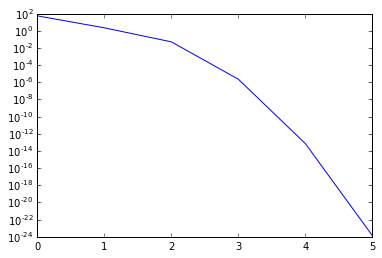

In [118]:
plt.plot([it['cost'] for it in summary['iterations'] ])
plt.semilogy();

In [38]:
import pandas as pd

In [39]:
del summary['iterations']

In [42]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * (np.pi/6.0))
n_points=10
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
            for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(np.array(point.vec()) 
                            + 0.09 * np.random.randn(3))).null() 
                  for point in points_b]
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b_noisy):
    mes.add_point_difference_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary, iterates) = mes.solve()
print(summary['brief_report'])

Ceres Solver Report: Iterations: 4, Initial cost: 6.089125e+01, Final cost: 3.023281e-01, Termination: CONVERGENCE


In [43]:
estimated_motor * motor.rev()

Mot: [ 1 -0.0056 -0.021 0.029 -0.04 0.032 3.6e-05 -0.00047 ]

In [129]:
print(summary['jacobian_evaluation_time_in_seconds'])

0.000337386969477


In [130]:
print(summary['total_time_in_seconds'])

0.00063508702442


In [123]:
pd.DataFrame(summary)

ValueError: If using all scalar values, you must pass an index